# Transaction Preliminary Analysis
Author: Nivethan Iyer


In this notebook we conduct some preliminary analysis to gain some understanding about our data.

In [6]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [2]:
path1 = "../../../data/raw/tables/transactions_20210228_20210827_snapshot/"
path2 = "../../../data/raw/tables/transactions_20210828_20220227_snapshot/"
path3 = "../../../data/raw/tables/transactions_20220228_20220828_snapshot/"
df_1 = spark.read.parquet(path1)
df_2 = spark.read.parquet(path2)
df_3 = spark.read.parquet(path3)
df = df_1.union(df_2).union(df_3)

df.show(5)
print("count", df.count())
df.printSchema()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



count 14195505
root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



First we analyse the distribution of the transactions

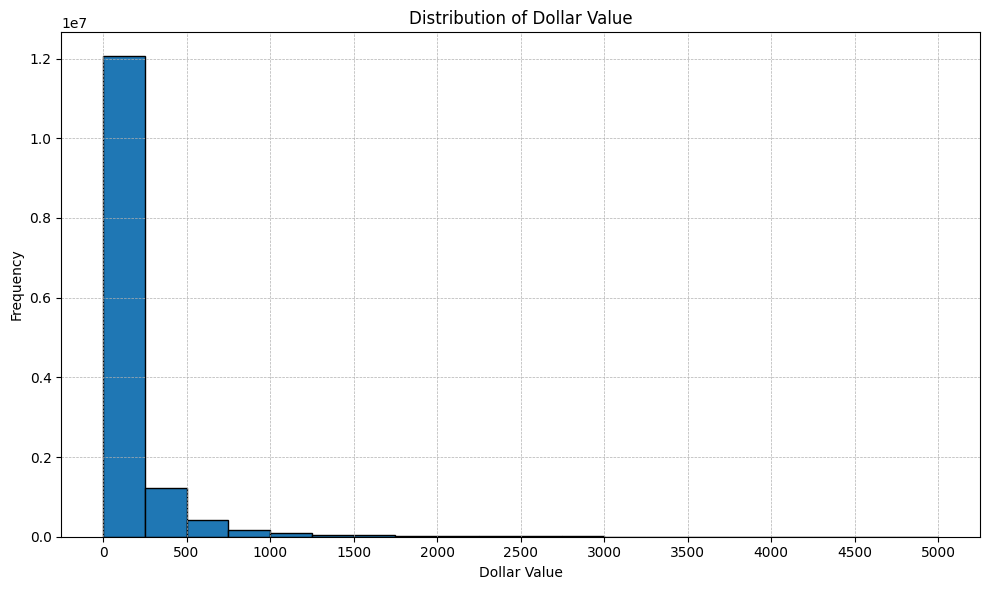

In [12]:
# Define the range and interval for x-axis
x_range = (0, 5000)
x_ticks_interval = 500
x_ticks = list(range(x_range[0], x_range[1] + x_ticks_interval, x_ticks_interval))
dollar_values = df.select('dollar_value').toPandas()['dollar_value']

# Plot the histogram with adjusted x-axis
plt.figure(figsize=(10, 6))
plt.hist(dollar_values, bins=20, edgecolor='black', range=x_range)
plt.xticks(x_ticks)
plt.xlabel('Dollar Value')
plt.ylabel('Frequency')
plt.title('Distribution of Dollar Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Then we group the dataset by merchants and analyse the transaction counts for each merchant

In [15]:
from pyspark.sql import functions as F

# Aggregating to get both transaction count and total dollar value for each merchant
merchant_transaction = df.groupBy("merchant_abn").agg(
    F.count("order_datetime").alias("transaction_count"),
    F.sum("dollar_value").alias("total_sales")
)

# Converting the result to a list
merchant_transaction_list = merchant_transaction.collect()
merchant_transaction_list[0:5]

[Row(merchant_abn=38700038932, transaction_count=6859, total_sales=8578511.315378312),
 Row(merchant_abn=83412691377, transaction_count=14288, total_sales=498536.5816973136),
 Row(merchant_abn=15613631617, transaction_count=1785, total_sales=543030.531332826),
 Row(merchant_abn=19839532017, transaction_count=726, total_sales=113982.0),
 Row(merchant_abn=73256306726, transaction_count=5263, total_sales=1496967.1591142188)]

We generate a histogram plot of the transactions counts for each merchant

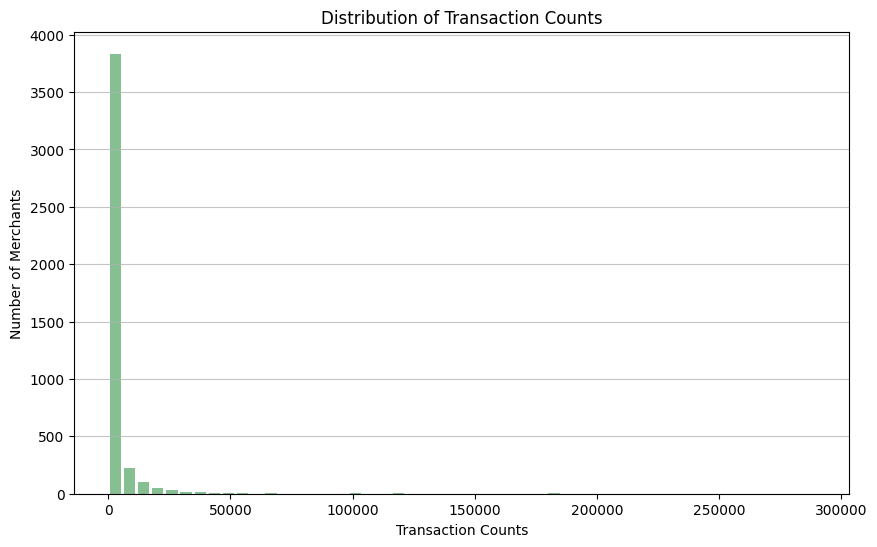

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting transaction counts for histogram
transaction_counts = [row['transaction_count'] for row in merchant_transaction_list]

plt.figure(figsize=(10,6))
plt.hist(transaction_counts, bins=50, color='#86bf91', rwidth=0.8)
plt.title('Distribution of Transaction Counts')
plt.xlabel('Transaction Counts')
plt.ylabel('Number of Merchants')
plt.grid(axis='y', alpha=0.75)
plt.show()





In [ ]:
spark.stop()
